<a href="https://www.kaggle.com/code/aleksandrmorozov123/object-detection-on-video?scriptVersionId=194462059" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aggressive-behavior-video-classification/aggressive_behavior.csv
/kaggle/input/aggressive-behavior-video-classification/files/aggressive/3.mp4
/kaggle/input/aggressive-behavior-video-classification/files/aggressive/1.mp4
/kaggle/input/aggressive-behavior-video-classification/files/aggressive/4.mp4
/kaggle/input/aggressive-behavior-video-classification/files/aggressive/0.mp4
/kaggle/input/aggressive-behavior-video-classification/files/aggressive/2.mp4
/kaggle/input/aggressive-behavior-video-classification/files/non_aggressive/5.mp4
/kaggle/input/aggressive-behavior-video-classification/files/non_aggressive/3.mp4
/kaggle/input/aggressive-behavior-video-classification/files/non_aggressive/1.mp4
/kaggle/input/aggressive-behavior-video-classification/files/non_aggressive/4.mp4
/kaggle/input/aggressive-behavior-video-classification/files/non_aggressive/0.mp4
/kaggle/input/aggressive-behavior-video-classification/files/non_aggressive/2.mp4


In [2]:
import torch
import os

In [3]:
# install YOLOv5
%cd {HOME}
!git clone https://github.com/ultralytics/yolov5

%cd {HOME}/yolov5
!pip install -r requirements.txt

from IPython import display
display.clear_output()

In [4]:
# install YOLOv8
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.82 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
Setup complete ✅ (4 CPUs, 31.4 GB RAM, 5845.9/8062.4 GB disk)


In [5]:
# install Detectron2
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

from IPython import display
display.clear_output()

import detectron2
print("detectron2:", detectron2.__version__)

detectron2: 0.6


In [6]:
# install Supervision
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision", sv.__version__)

supervision 0.23.0


In [7]:
from ultralytics import YOLO
model = YOLO ('yolov8s.pt')

100%|██████████| 21.5M/21.5M [00:00<00:00, 37.3MB/s]


**Object detection with YOLOv8**


0: 736x1280 9 persons, 8 cars, 45.3ms
Speed: 18.4ms preprocess, 45.3ms inference, 224.5ms postprocess per image at shape (1, 3, 736, 1280)


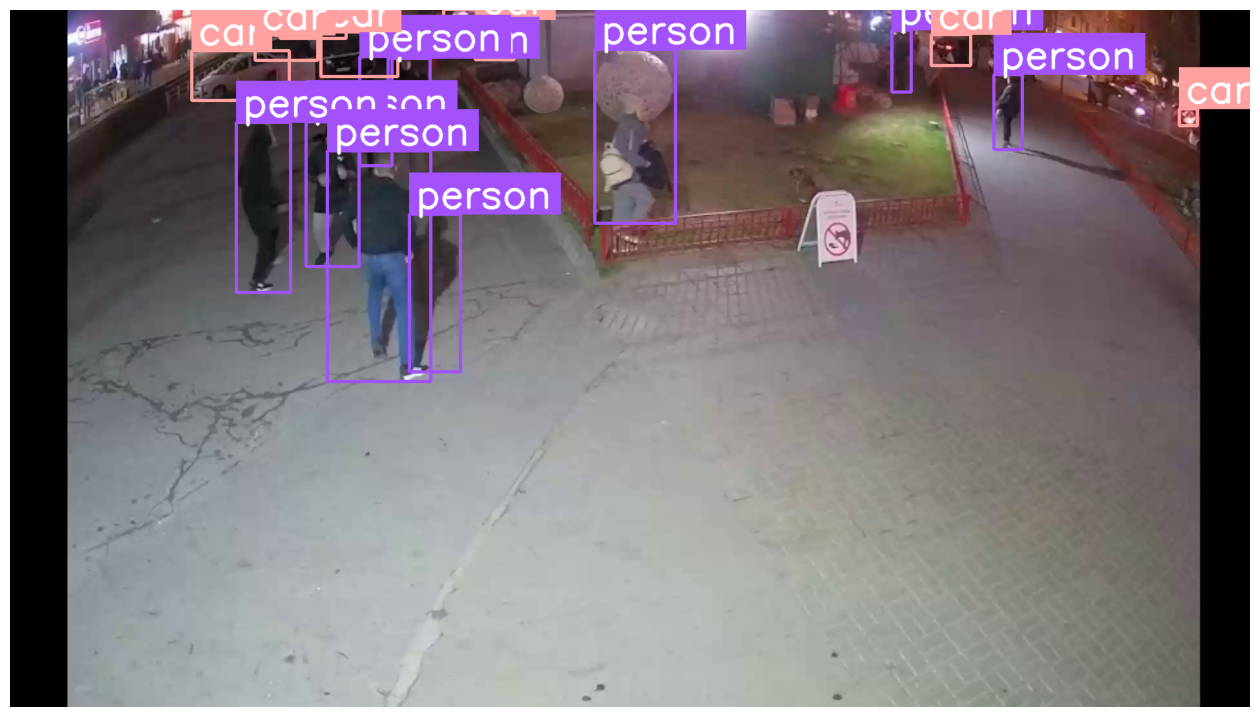

In [8]:
import supervision as sv
%matplotlib inline
import numpy as np

# extract video frame
generator = sv.get_video_frames_generator ('/kaggle/input/aggressive-behavior-video-classification/files/aggressive/1.mp4')
iterator = iter (generator)
frame = next (iterator)

# detect
results = model (frame, imgsz = 1280)[0]
detections = sv.Detections.from_ultralytics (results)

# annotate
box_annotator= sv.BoxAnnotator (thickness = 4)
label_annotator = sv.LabelAnnotator (text_thickness = 4, text_scale = 2)
frame = box_annotator.annotate (scene = frame, detections = detections)
frame = label_annotator.annotate (scene = frame, detections = detections)

sv.plot_image (frame, (16, 16))


0: 736x1280 9 persons, 8 cars, 13.9ms
Speed: 11.3ms preprocess, 13.9ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


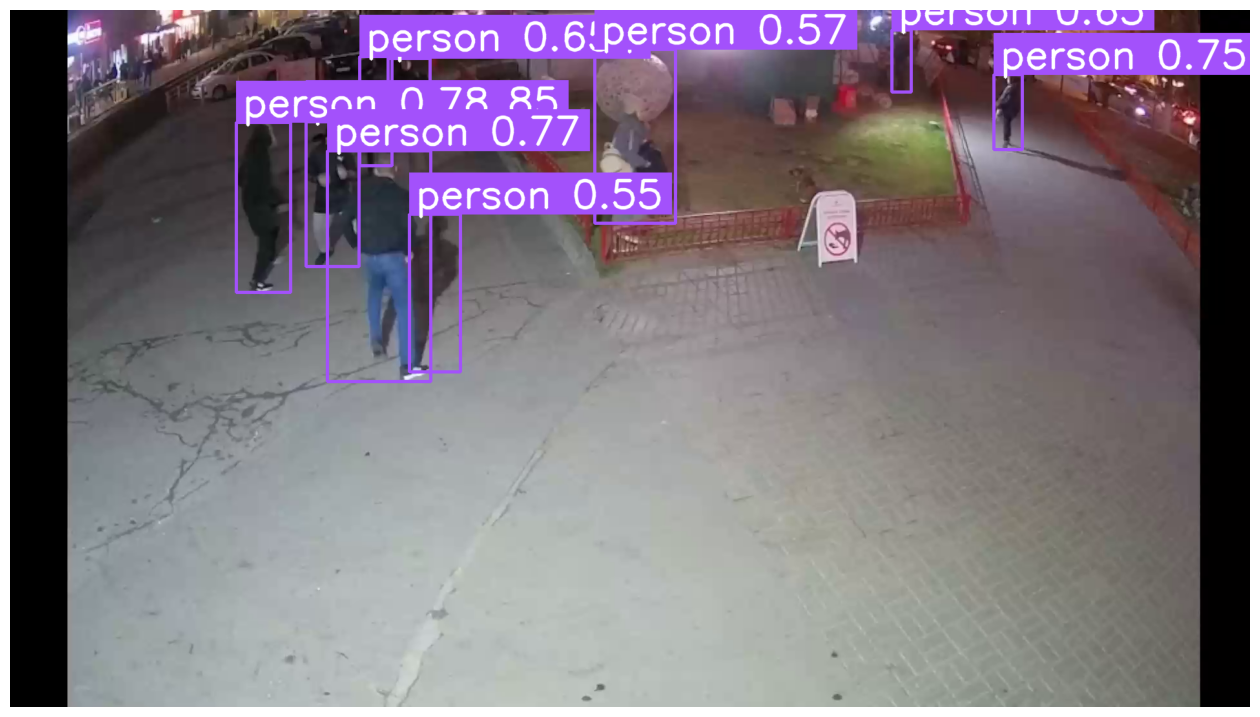

In [9]:
# extract video frame
generator = sv.get_video_frames_generator ('/kaggle/input/aggressive-behavior-video-classification/files/aggressive/1.mp4')
iterator = iter (generator)
frame = next (iterator)

# detect
results = model (frame, imgsz = 1280)[0]
detections = sv.Detections.from_ultralytics (results)
detections = detections [detections.class_id == 0]

# annotate
box_annotator= sv.BoxAnnotator (thickness = 4)
label_annotator = sv.LabelAnnotator (text_thickness = 4, text_scale = 2)
labels = [f'{model.names[class_id]} {confidence:0.2f}' for _, _, confidence, class_id, _, _ in detections]
frame = box_annotator.annotate (scene = frame, detections = detections)
frame = label_annotator.annotate (scene = frame, detections = detections, labels = labels)

sv.plot_image (frame, (16, 16))


0: 736x1280 9 persons, 8 cars, 13.9ms
Speed: 8.2ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


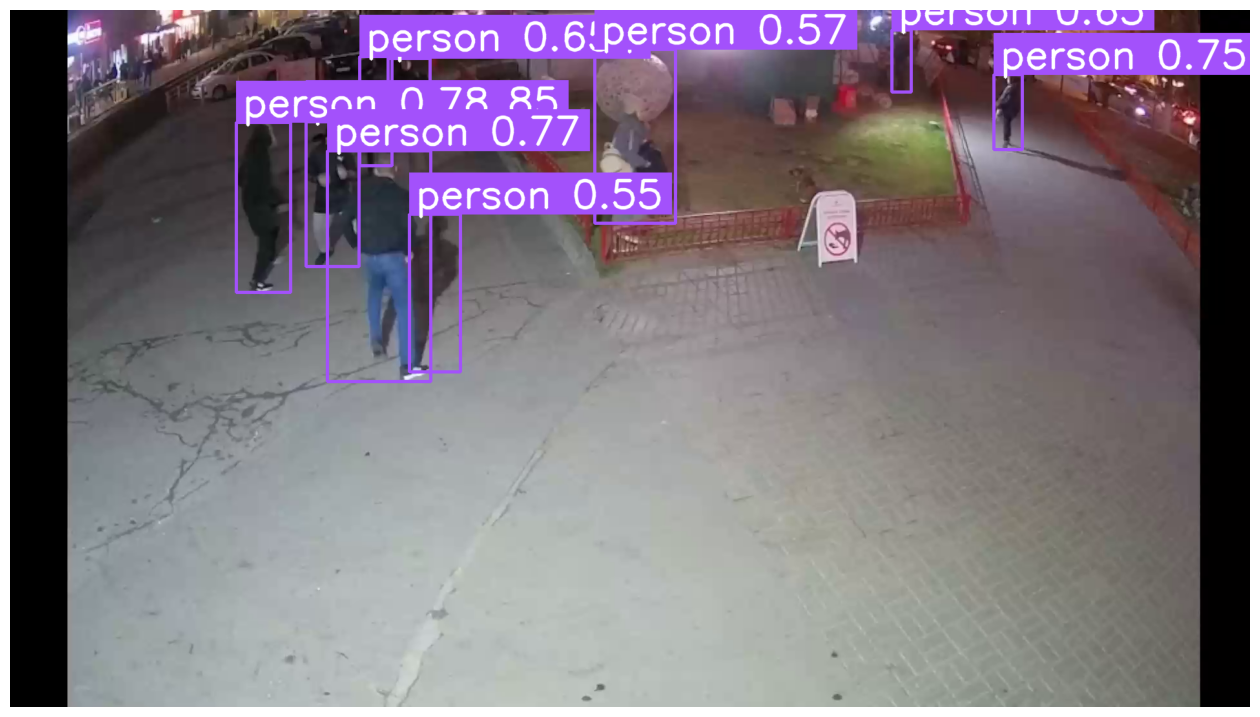

In [10]:
# initiate polygon zone
polygon = np.array([
    [1725, 1550],
    [2725, 1550],
    [3500, 2160],
    [1250, 2160]
])
video_info = sv.VideoInfo.from_video_path ('/kaggle/input/aggressive-behavior-video-classification/files/aggressive/1.mp4')
zone = sv.PolygonZone (polygon = polygon)

# initiate annotators
box_annotator = sv.BoxAnnotator (thickness = 4)
label_annotator = sv.LabelAnnotator (text_thickness = 4, text_scale = 2)
zone_annotator = sv.PolygonZoneAnnotator (zone = zone, color = sv.Color.WHITE,
                                         thickness = 6, text_thickness = 6, text_scale = 4)

# extract video frame
generator = sv.get_video_frames_generator ('/kaggle/input/aggressive-behavior-video-classification/files/aggressive/1.mp4')
iterator = iter (generator)
frame = next (iterator)

# detect
results = model (frame, imgsz = 1280)[0]
detections = sv.Detections.from_ultralytics (results)
detections = detections [detections.class_id == 0]
zone.trigger (detections = detections)

# annotate
labels = [f'{model.names[class_id]} {confidence:0.2f}' for _, _, confidence, class_id, _, _ in detections]
frame = box_annotator.annotate (scene = frame, detections = detections)
frame = label_annotator.annotate (scene = frame, detections = detections, labels = labels)
frame = zone_annotator.annotate (scene = frame)

sv.plot_image (frame, (16, 16))


0: 736x1280 9 persons, 8 cars, 13.9ms
Speed: 6.1ms preprocess, 13.9ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)


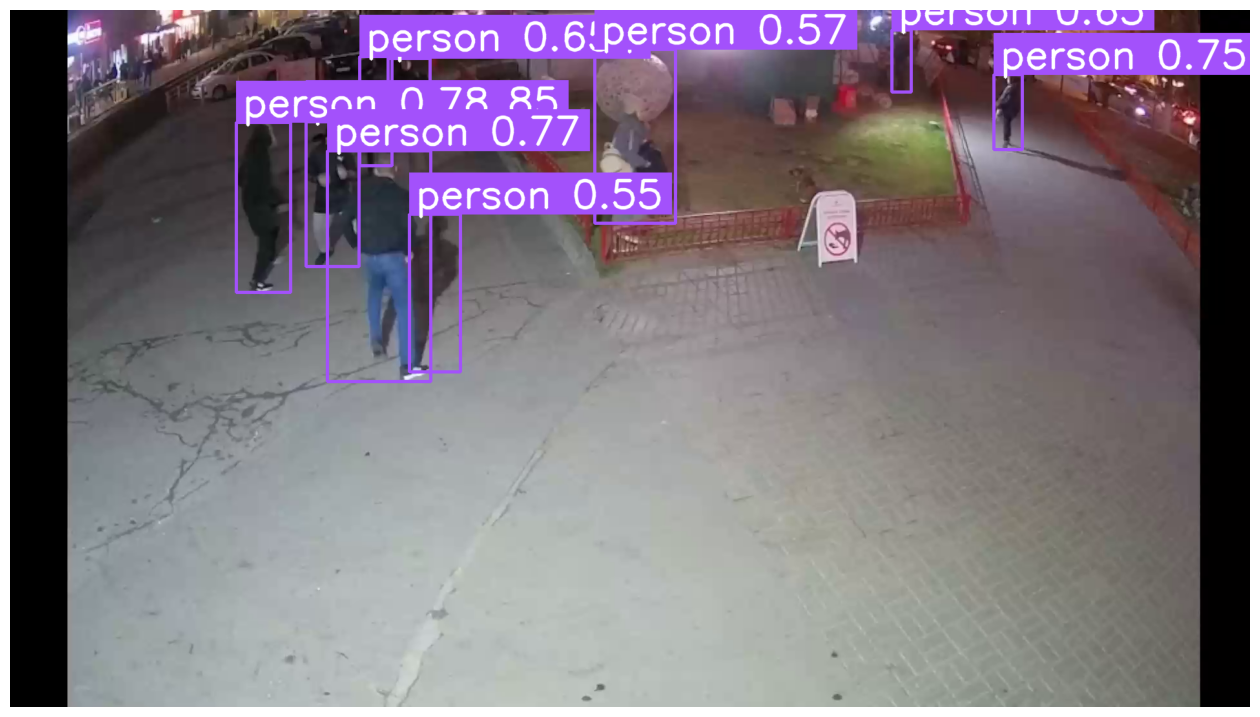

In [11]:
# initiate polygon zone
polygon = np.array([
    [1725, 1550],
    [2725, 1550],
    [3500, 2160],
    [1250, 2160]
])
video_info = sv.VideoInfo.from_video_path ('/kaggle/input/aggressive-behavior-video-classification/files/aggressive/1.mp4')
zone = sv.PolygonZone (polygon = polygon)

# initiate annotators
box_annotator = sv.BoxAnnotator (thickness = 4)
label_annotator = sv.LabelAnnotator (text_thickness = 4, text_scale = 2)
zone_annotator = sv.PolygonZoneAnnotator (zone = zone, color = sv.Color.WHITE,
                                         thickness = 6, text_thickness = 6, text_scale = 4)

# extract video frame
generator = sv.get_video_frames_generator ('/kaggle/input/aggressive-behavior-video-classification/files/aggressive/1.mp4')
iterator = iter (generator)
frame = next (iterator)

# detect
results = model (frame, imgsz = 1280)[0]
detections = sv.Detections.from_ultralytics (results)
detections = detections [detections.class_id == 0]
zone.trigger (detections = detections)

# annotate
labels = [f'{model.names[class_id]} {confidence:0.2f}' for _, _, confidence, class_id, _, _ in detections]
frame = box_annotator.annotate (scene = frame, detections = detections)
frame = label_annotator.annotate (scene = frame, detections = detections, labels = labels)
frame = zone_annotator.annotate (scene = frame)

sv.plot_image (frame, (16, 16))

**Process whole video and obtain video file in result**

In [12]:
# initiate polygon zone
polygon = np.array ([
    [700, 1200],
    [710, 1200],
    [710, 1160],
    [710, 1160]
])

video_info = sv.VideoInfo.from_video_path ('/kaggle/input/aggressive-behavior-video-classification/files/aggressive/1.mp4')
zone = sv.PolygonZone (polygon = polygon)

# initiate annotators
box_annotator = sv.BoxAnnotator (thickness = 4)
label_annotator = sv.LabelAnnotator (text_thickness = 4, text_scale = 2)
zone_annotator = sv.PolygonZoneAnnotator (zone = zone, color = sv.Color.WHITE,
                                         thickness = 6, text_thickness = 6, text_scale = 4)

def process_frame (frame: np.ndarray, _) -> np.ndarray:
    # detect
    results = model (frame, imgsz = 1280)[0]
    detections = sv.Detections.from_ultralytics (results)
    detections = detections [detections.class_id == 0]
    zone.trigger (detections=detections)
    
    # annotate
    labels = [f"{model.names[class_id]} {confidence:0.2f}" for _, _, confidence, class_id, _, _ in detections]
    frame = box_annotator.annotate (scene = frame, detections = detections)
    frame = label_annotator.annotate (scene=frame, detections = detections, labels = labels)
    frame = zone_annotator.annotate (scene = frame)
    return frame

sv.process_video (source_path = '/kaggle/input/aggressive-behavior-video-classification/files/aggressive/1.mp4',
                 target_path = f"/kaggle/working/result.mp4", callback = process_frame)

from IPython import display
display.clear_output ()

**Working with Detectron**

model_final_f10217.pkl: 178MB [00:01, 119MB/s]                           


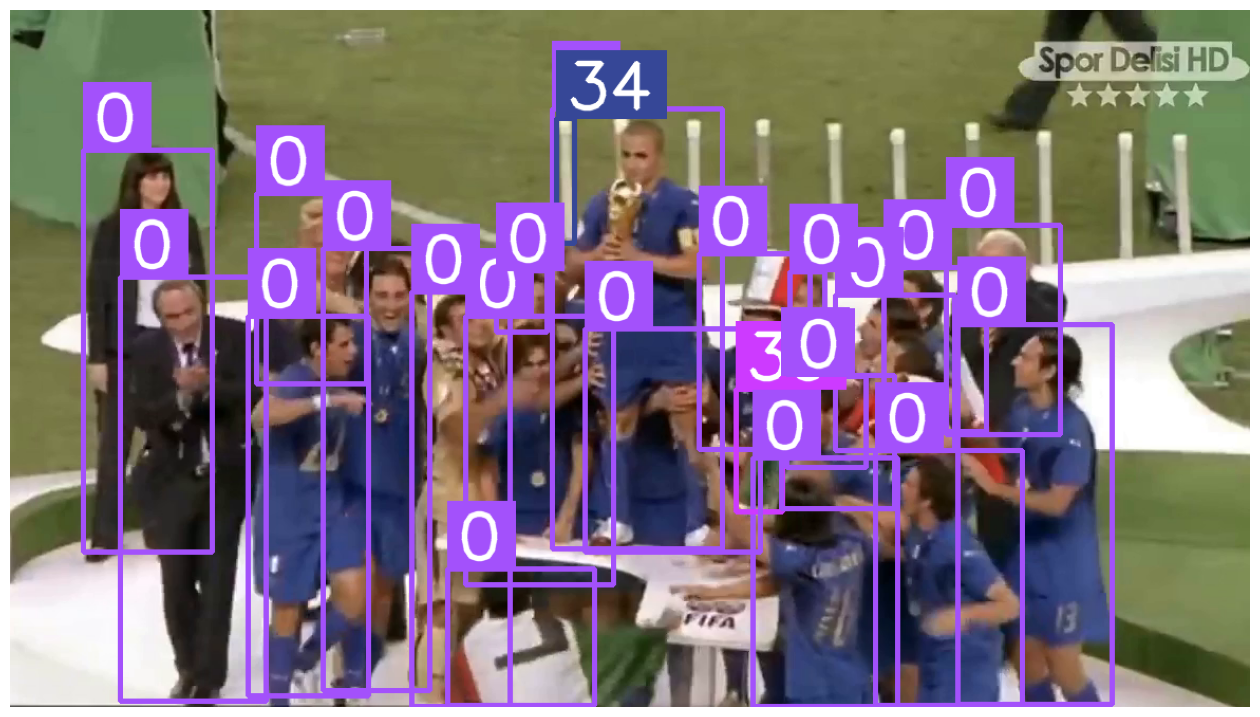

In [13]:
# import required libraries
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

cfg = get_cfg ()
cfg.merge_from_file (model_zoo.get_config_file ('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml'))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url ('COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml')
predictor = DefaultPredictor (cfg)

# extract video frame 
generator = sv.get_video_frames_generator ('/kaggle/input/aggressive-behavior-video-classification/files/non_aggressive/3.mp4')
iterator = iter (generator)
frame = next (iterator)

# detect
outputs = predictor (frame)
detections = sv.Detections(xyxy = outputs['instances'].pred_boxes.tensor.cpu().numpy(),
                            confidence = outputs ['instances'].scores.cpu().numpy(),
                            class_id = outputs ['instances'].pred_classes.cpu().numpy().astype(int))
                           

# annotate
box_annotator = sv.BoxAnnotator (thickness = 4)
label_annotator = sv.LabelAnnotator (text_thickness = 4, text_scale = 2)
frame = box_annotator.annotate (scene = frame, detections = detections)
frame = label_annotator.annotate (scene = frame, detections = detections)

sv.plot_image (frame, (16, 16))